In [19]:
from web3 import Web3
import pandas as pd
import os, sys, json
from matplotlib import pyplot as plt
import numpy as np
from dotenv import load_dotenv
load_dotenv('../.env')

# Scripts
scripts_module_path = os.path.abspath(os.path.join(os.getcwd(),'..', 'scripts'))
if scripts_module_path not in sys.path:
    sys.path.append(scripts_module_path)
from acquisition import Acquisition as Akw
w3 = Web3(Web3.HTTPProvider(os.getenv("ALECHEMY_MAINNET_ENDPOINT")))
# w3 = Web3(Web3.IPCProvider('/home/leonhard/.ethereum/geth.ipc'))
print("JSON RPC for Alchemy is connected: ", w3.isConnected())

JSON RPC for Alchemy is connected:  False


### Get MIM events

In [4]:
MIM_contract = "MIM_ERC20_Mainnet"
filepath = f'../data/contracts/{MIM_contract}.json'
with open(filepath, 'r') as fl:
    interace = json.load(fl)
    ABI = json.dumps(interace["interface"])
    address = list(interace["addresses"].values())[0]
mim_contract = w3.eth.contract(address=address, abi=ABI)
contr_mim = mim_contract.caller()

In [5]:
CauldronWethV2 = "CauldronWethV2"
filepath = f'../data/contracts/{CauldronWethV2}.json'
with open(filepath, 'r') as fl:
    interace = json.load(fl)
    ABI = json.dumps(interace["interface"])
    address = list(interace["addresses"].values())[0]
contract_vault = w3.eth.contract(address=address, abi=ABI)
contr_vault = contract_vault.caller()

### Holders

In [54]:
filename = 'export-tokenholders-for-contract-0x99D8a9C45b2ecA8864373A26D1459e3Dff1e17F3.csv'
df = pd.read_csv('../data/blockscanner/' + filename , sep=',')
df = df.astype({'Balance': 'int64'}).copy()

In [55]:
df.describe()

,Balance
count,4.836000e+03
mean,9.610649e+05
std,3.675028e+07
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,8.325000e+01
max,1.975023e+09


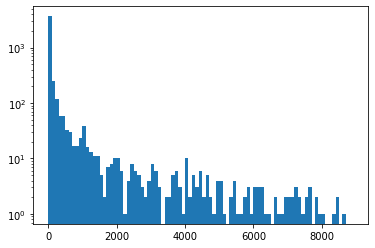

In [56]:
bins = np.arange(0,9*10**3, 10*10**1)
n, bins, patches = plt.hist(df.Balance.values, bins=bins, log=True)
plt.show()

## Collateral removed

In [52]:
randomBlock = 12949454
myfilter = contract_vault.events.LogRemoveCollateral.createFilter(fromBlock=randomBlock, toBlock='latest')
events = myfilter.get_all_entries()

In [53]:
cols = ["blockNumber", "share"]
rmCol_df = pd.DataFrame(data={i:{cols[0]:e[cols[0]], cols[1]: e["args"][cols[1]]} for i,e in enumerate(events)}).T

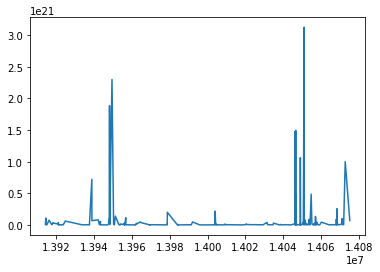

In [51]:
# rmCol_df.plot("blockNumber", "share")
plt.plot(rmCol_df["blockNumber"], rmCol_df["share"])
ax = plt.gca()
# ax.set_yscale('log')

### Markets

In [116]:
def assign_row_entries(row, verbose=True):
    name = row[0].replace('\n', '')
    name = name[:int(len(name)/2)]
    pair = row[1].replace('\t', '').replace('\n','')
    price = row[2].replace('\t', '').replace('\n','')
    convolved = row[3].replace('\n', '').split('\t')
    if (len(convolved) == 5):
        other_info = convolved[0]
        spread = convolved[1]
        depth_plus_2 = convolved[2]
        depth_minus_2 = convolved[3]
    else:
        if verbose==True:
            print(convolved)
        
        other_info = ''
        spread = ''
        depth_plus_2 = ''
        depth_minus_2 = ''
    volume_dollar_24h = row[4].replace('\t', '').replace('\n','')
    conv = row[5].split('\t')
    volume_coin_24h = conv[0]
    Volume_perc = conv[1]
    Last_traded = conv[2]
    Trust_score = conv[3].replace('\n', '')
    return dict(
        name=name,
        pair=pair,
        price=price,
        volume_dollar_24h=volume_dollar_24h,
        volume_coin_24h=volume_coin_24h,
        depth_minus_2=depth_minus_2,
        depth_plus_2=depth_plus_2,
        other_info=other_info,
        Volume_perc=Volume_perc,
        spread=spread,
        Last_traded=Last_traded,
        Trust_score=Trust_score
    )